# Modeling and Simulation in Python

Chapter 9: Projectiles

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second

In [3]:
init = State(y=381 * m, 
             v=0 * m/s)
init

,value
y,381 meter
v,0.0 meter / second


In [4]:
g = 9.8 * m/s**2

In [5]:
duration = 10 * s
ts = linspace(0, duration, 11)
ts

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [6]:
system = System(init=init, g=g, ts=ts)

In [7]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    """
    y, v = state
    unpack(system)    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

In [8]:
slopes = slope_func(init, 0, system)
slopes

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

In [9]:
run_odeint(system, slope_func)

In [10]:
system.results.head()

,y,v
0.0,381.0,0.0
1.0,376.1,-9.8
2.0,361.4,-19.6
3.0,336.9,-29.4
4.0,302.6,-39.2


In [11]:
system.results.tail()

,y,v
6.0,204.6,-58.8
7.0,140.9,-68.6
8.0,67.4,-78.4
9.0,-15.9,-88.2
10.0,-109.0,-98.0


In [12]:
def plot_results(results):
    newfig()
    plot(results.y, label='y')
    if hasattr(results, 'x'):
        plot(results.x, label='x')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

<IPython.core.display.Javascript object>


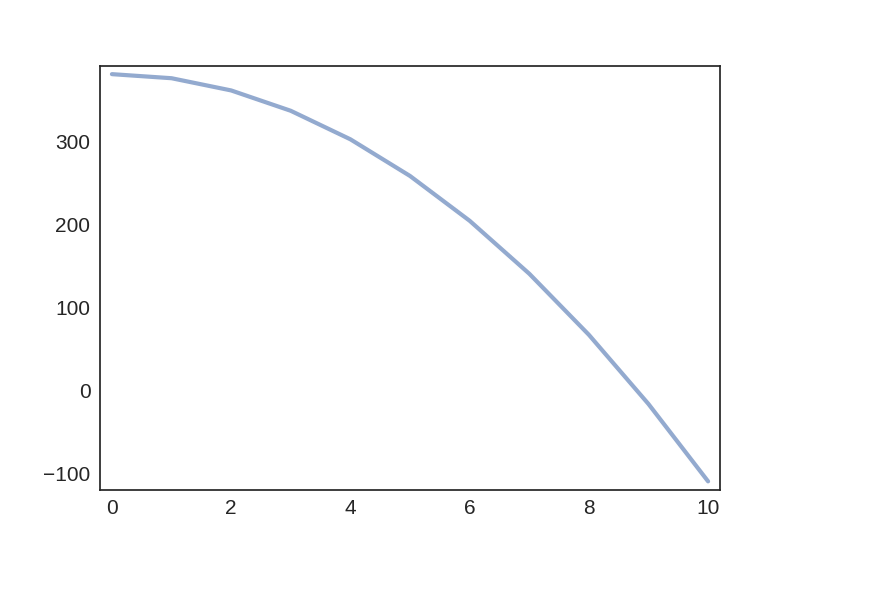

Saving figure to file chap09-fig01.pdf


In [13]:
plot_results(system.results)
savefig('chap09-fig01.pdf')

### Onto the sidewalk

In [14]:
y = system.results.y
inverse = Series(data=y.index, index=y.data)
inverse

 381.0     0.0
 376.1     1.0
 361.4     2.0
 336.9     3.0
 302.6     4.0
 258.5     5.0
 204.6     6.0
 140.9     7.0
 67.4      8.0
-15.9      9.0
-109.0    10.0
dtype: float64

In [15]:
T = interpolate(inverse, kind='cubic')

In [16]:
T_sidewalk = T(0)
T_sidewalk

array(8.81792826905006)

In [17]:
sqrt(2 * init.y / g)

<Quantity(8.817885349720552, 'second')>

In [18]:
def make_system(duration):
    init = State(y=381 * m, v=0 * m/s)

    g = 9.8 * m/s**2
    ts = linspace(0, duration, 101)
    return System(init=init, g=g, ts=ts)

In [19]:
system = make_system(T_sidewalk)
run_odeint(system, slope_func)

In [20]:
# TODO: comments on getting the units back

def final_state(system):
    t_end = system.results.index[-1]
    y, v = system.results.loc[t_end]
    return y*m, v*m/s

In [21]:
y_final, v_final = final_state(system)
y_final

<Quantity(-0.00370889540005237, 'meter')>

In [22]:
v_final

<Quantity(-86.4156970366906, 'meter / second')>

In [23]:
km = UNITS.kilometer
h = UNITS.hour
v_final.to(km / h)

<Quantity(-311.09650933208616, 'kilometer / hour')>

**Exercise:** Go back and increase the number of timesteps and see if that improves the estimate of `T_sidewalk`.

### With air resistance

https://en.wikipedia.org/wiki/Drag_equation

In [25]:
kg = UNITS.kilogram

g = 9.8 * m/s**2
mass = 2.5e-3 * kg
diameter = 19e-3 * m
rho = 1.2 * kg/m**3
v_term = 18 * m / s
area = np.pi * (diameter/2)**2

C_d = 2 * mass * g / (rho * area * v_term**2)
C_d

<Quantity(0.4445009981135434, 'dimensionless')>

In [26]:
condition = Condition(height = 381 * m,
                      g = 9.8 * m/s**2,
                      mass = 2.5e-3 * kg,
                      diameter = 19e-3 * m,
                      rho = 1.2 * kg/m**3,
                      v_term = 18 * m / s,
                      duration = 30)

In [28]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=0 * m/s)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, ts=ts)

In [29]:
system = make_system(condition)
system

,value
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
mass,0.0025 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.4445009981135434 dimensionless
area,0.0002835287369864788 meter ** 2
ts,"[0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, ..."


In [30]:
def slope_func(state, t, system):
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

In [31]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

In [32]:
run_odeint(system, slope_func)

In [33]:
final_state(system)

(<Quantity(-136.083704279796, 'meter')>,
 <Quantity(-18.00000000087864, 'meter / second')>)

In [34]:
y = system.results.y
inverse = Series(data=y.index, index=y.data)
T = interpolate(inverse, kind='cubic')
t_sidewalk = T(0)
t_sidewalk

array(22.439794207078908)

In [35]:
condition.set(duration=t_sidewalk)
system = make_system(condition)
run_odeint(system, slope_func)
y_final, v_final = final_state(system)

In [36]:
y_final, v_final

(<Quantity(1.2732392917769175e-10, 'meter')>,
 <Quantity(-18.00000000874157, 'meter / second')>)

<IPython.core.display.Javascript object>


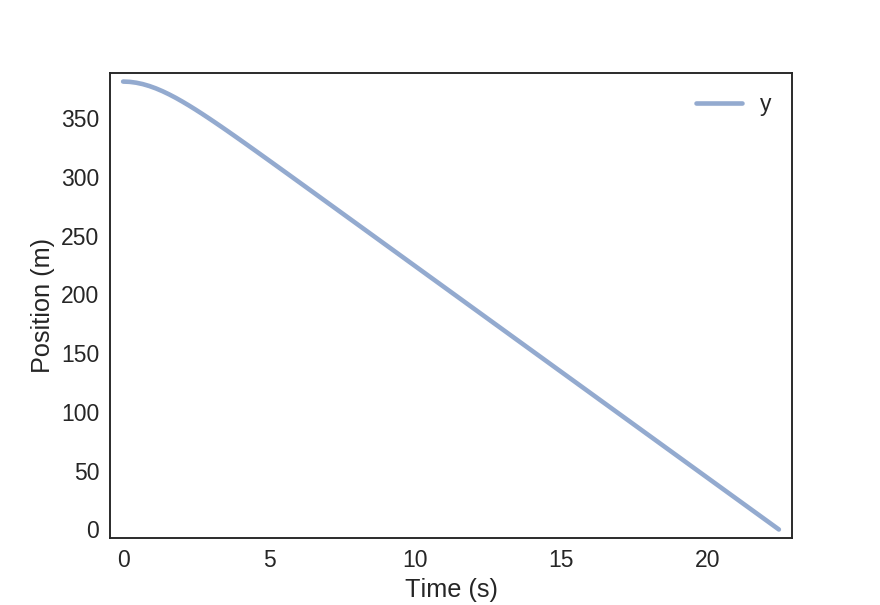

Saving figure to file chap09-fig02.pdf


In [37]:
plot_results(system.results)
savefig('chap09-fig02.pdf')

### Baseball

In [38]:
degree = UNITS.degree

angle = 45 * degree
angle

<Quantity(45, 'degree')>

In [39]:
angle.to(UNITS.radian)

<Quantity(0.7853981633974483, 'radian')>

In [40]:
condition = Condition(g = 9.8 * m/s**2,
                      mass = 145e-3 * kg,
                      diameter = 73e-3 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.3,
                      angle = 45 * degree,
                      velocity = 40 * m / s,
                      duration = 5)

In [ ]:
def make_system(condition):
    unpack(condition)
    
    x, y = 0 * m, 0 * m
    theta = np.deg2rad(angle)
    vx, vy = pol2cart(theta, velocity)
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    area = np.pi * (diameter/2)**2
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

In [ ]:
system = make_system(condition)
system.init

In [ ]:
def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    f_drag = -rho * v.mag**2 * C_d * area / 2 * v.hat()
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return v.x, v.y, a.x, a.y

In [ ]:
slope_func(system.init, 0, system)

In [ ]:
run_odeint(system, slope_func)

In [ ]:
system.results.head()

In [ ]:
system.results.tail()

In [ ]:
xs = system.results.x
ys = system.results.y

In [ ]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

In [ ]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

In [ ]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 105],
         ylim=[-5, 35],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

In [ ]:
def animate2d(xs, ys, speedup=1):
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

In [ ]:
# animate2d(system.results.x, system.results.y)

In [ ]:
def final_state(system):
    t_end = system.results.index[-1]
    y, v = system.results.loc[t_end]
    return y*m, v*m/s

In [ ]:
def height_func(duration, condition):
    
    condition.set(duration=duration)
    
    system = make_system(condition)
    
    run_odeint(system, slope_func)
    
    t_end = system.results.index[-1]
    y_final = system.results.y[t_end]
    
    return y_final

In [ ]:
height_func(5, condition)

In [ ]:
%time solution = fsolve(height_func, 5, condition, xtol=1e-2)
solution

In [ ]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      C_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 5)

In [ ]:
height_func(5, condition)

In [ ]:
%time solution = fsolve(height_func, 5, condition, xtol=1e-2)
solution

In [ ]:
def final_range(results):
    return results.x.iloc[-1]

In [ ]:
condition.set(duration=solution)
    
system = make_system(condition)
    
run_odeint(system, slope_func)
final_range(system.results)

In [ ]:
def range_func(angle, condition):
    print(angle)
    
    if angle < 0 or angle > 90:
        raise ValueError('Invalid angle: %s' % angle)
    
    condition.set(angle=angle)
    solution = fsolve(height_func, 5, condition, xtol=1e-2)
    
    condition.set(duration=solution)
    system = make_system(condition)
    
    run_odeint(system, slope_func)
    
    x_final = final_range(system.results)
    #print(x_final)
    return -x_final


In [ ]:
angle = 40
range_func(angle, condition)

In [ ]:
condition.set(C_d=0.7)

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
args = (condition,)
options = dict(xatol=1e-3)
res = minimize_scalar(range_func, [10, 80], bounds=[0, 90], args=args, 
                method='bounded', options=options)

In [ ]:
res.x